In [1]:
%pylab
import glob
from scipy.ndimage import imread
from scipy.ndimage.interpolation import zoom
from scipy.misc import imresize
import pandas as pd
import seaborn as sns
sns.set_style('white')
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# load and preprocess data

In [2]:
labels = pd.read_csv('labels.csv')
labels.columns = ['digit', 'label']

In [3]:
labels.head()

digit  label
0  digit_1      4
1  digit_2      2
2  digit_3      3
3  digit_4      1
4  digit_5      2

**create one-hot-encoding array for later purpose**

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 2 columns):
digit    1392 non-null object
label    1392 non-null int64
dtypes: int64(1), object(1)
memory usage: 21.8+ KB


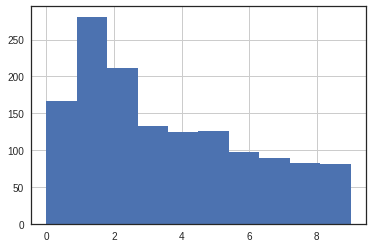

In [5]:
labels.label.hist()

the data are not perfectly balanced but chance level would still be <0.2

*one-hot-encoding*

In [6]:
dummies = pd.get_dummies(labels, columns = ['label'], )
one_hot_labels =array(dummies.drop('digit', axis = 1))

In [7]:
image_list = []
# bring in order according to labels.xls
for filename in sorted(glob.glob('BDRW_train/*.jpg'), key=lambda a: int(a.split("_")[-1].split('.')[0]))[1:]: #because digit_0 not in labels
    im=imread(filename)
    image_list.append(array(im))

plot distribution of image sizes

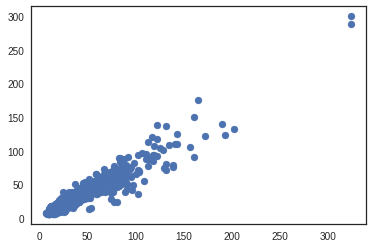

In [9]:
shapes = array([x.shape for x in image_list]).T
scatter(shapes[0], shapes[1])

In [10]:
mean(shapes[:2], 1)

array([ 35.4612069 ,  27.83333333])

**rescale all images to 35x28 and fill open space with mean of boundary line**

In [11]:
def resize_and_fill(im, X=35, Y = 28):
    i = argmin(im.shape[:2])
    i = im.shape[0]/float(im.shape[1]) >= 1.25
    if i == 0:
        test_im = imresize(im, (int(im.shape[0]*float(Y)/im.shape[1]) , Y, 3) )
    if i == 1:
        test_im = imresize(im, (X, int(im.shape[1]*float(X)/im.shape[0]), 3) )

    shape_test = array(test_im.shape[:2])
    test_im2 = ones((X, Y ,3))
    if i == 0:
        for k in range(3):
            test_im2[:, :, k] = concatenate((test_im[:,:,k], ones((X-shape_test[0], Y))*mean(test_im[-1,:,k])), 0)

    if i == 1:
        for k in range(3):
            test_im2[:, :, k] = concatenate((test_im[:,:,k], ones((X, Y-shape_test[1]))*mean(test_im[:,-1,k])), 1)
    return test_im2.astype(uint8)

In [12]:
adjusted_im = array([resize_and_fill(x) for x in image_list])

**augment data by simple inversion of color channels**

In [13]:
adjusted_im2 = append(adjusted_im, array([x[:,:,[1,0,2]] for x in adjusted_im]), 0)
one_hot_labels2 = append(one_hot_labels, one_hot_labels, 0)

/home/herfurtht/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 1392 + 1) instead


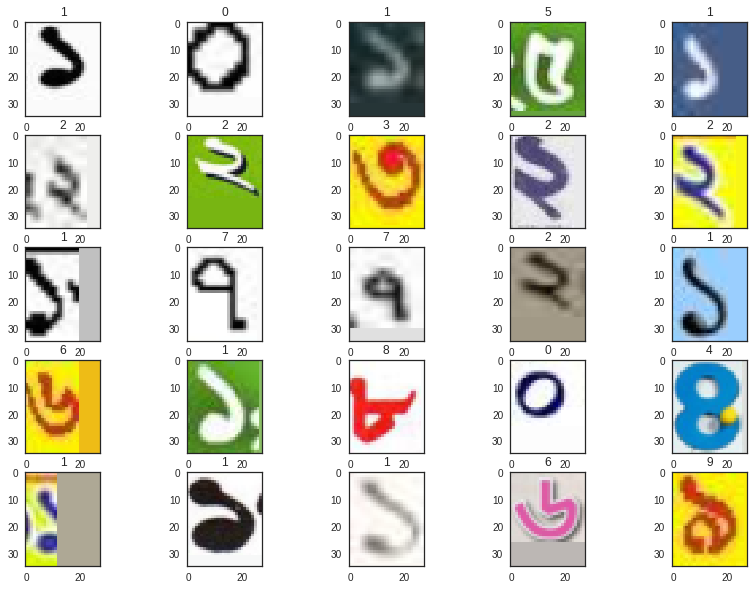

In [14]:
fig, ax = subplots(5, 5, figsize = (14, 10))
for x in range(5):
    for y in range(5):
        rn = random_integers(0, len(adjusted_im))
        ax[x,y].imshow(adjusted_im[rn])
        ax[x,y].set_title(labels.label.iloc[rn])
show()

# Build CNN in Keras

In [16]:
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import keras.backend as K

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

Using TensorFlow backend.


In [17]:
K.clear_session()

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Dropout(0.3, input_shape=((35, 28, 3))))
model.add(Conv2D(32, (3, 3), input_shape=(35, 28, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

In [19]:
model.add(Flatten())  #3D feature maps to 1D feature vectors
model.add(Dense(64, kernel_regularizer= 'l2'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, kernel_regularizer= 'l2'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'],
             callbacks = [earlyStopping])

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 35, 28, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 26, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 33, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 11, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 14, 11, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 5, 32)          0         
__________

In [21]:
X_train, X_test, y_train, y_test = train_test_split(adjusted_im2, one_hot_labels2, test_size = .1)

In [22]:
%%time

hist = model.fit(X_train, y_train, epochs = 150, batch_size = 64, verbose = True)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs
Epoch 1/150
 128/2505 [>.............................] - ETA: 3s - loss: 15.5770 - acc: 0.0859

/home/herfurtht/miniconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:2094: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


2505/2505 [==============================] - 2s - loss: 15.0080 - acc: 0.1142     

[0.08265043106130375, 0.99641577060931896]

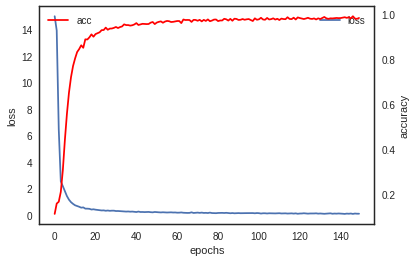

In [23]:
figure()
xlabel('epochs')
plot(hist.history['loss'])
ylabel('loss')
legend(['loss'])
twinx(gca())
plot(hist.history['acc'], 'r')
ylabel('accuracy')
legend(['acc'])
show()

In [27]:
print('loss, accuracy = ', model.evaluate(X_test, y_test))

279/279 [==============================] - 0s     
('loss, accuracy = ', [0.08265043106130375, 0.99641577060931896])


we can reach a very high accuracy here. this was not possible without using the pseudo-augmented data obtained from color inversion